In [96]:
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from robotik_anwendungen.camera import IPCamera
import logging
import imutils
# matplotlib.use('TkAgg')


# matplotlib.use('TkAgg')
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [97]:
class Detector:
    RESIZE_WIDTH = RESIZE_HEIGHT = 400
    @staticmethod
    def from_image(image: np.ndarray, debug=True):
        logger.info(f'Received image of size: {image.shape}')
        original_image = image.copy()
        Detector.__auto_debug_plot(debug, image, 'Original')
        adaptive_thresh, image = Detector.__normalise_image(image, debug)
        mask = Detector.__extract_mask(adaptive_thresh, image, debug=debug)
        edges, color_edges = Detector.__find_edges(mask)
        logger.info(f'Output image: {image.shape}')


    @staticmethod
    def __normalise_image(image, debug=True):
        image = imutils.resize(image, Detector.RESIZE_WIDTH, Detector.RESIZE_HEIGHT)
        image = cv.GaussianBlur(image, (7, 7), 0)
        # image = cv.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        # image = cv.bilateralFilter(image, 9, 75, 75)
        # image = Detector.vignette_filter(image)
        image = Detector.__unsharp_mask(image)
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        adaptive_thresh = cv.adaptiveThreshold(gray_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 125, 2)
        Detector.__auto_debug_plot(debug, adaptive_thresh, 'Adaptive threshold', None, cmap='gray')
        return adaptive_thresh, image

    @staticmethod
    def __extract_mask(adaptive_thres, img, debug=True):
        contours, hierarchy = cv.findContours(adaptive_thres, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        imgContours = img.copy()
        largest_ratio = largest_perimeter = largest_area = 0
        largest_contour = []
        for c in range(len(contours)):
            area = cv.contourArea(contours[c])
            perimeter = cv.arcLength(contours[c], True)
            if perimeter > 0:
                ratio = area / perimeter
                if ratio > largest_ratio:
                    largest_contour = contours[c]
                    largest_ratio = ratio
                    largest_perimeter = perimeter
                    largest_area = area
        cv.drawContours(imgContours, [largest_contour], -1, (255, 0, 0), 1)
        Detector.__auto_debug_plot(debug, imgContours, 'Image Contour')
        epsilon = 0
        edge = cv.approxPolyDP(largest_contour, epsilon, True)
        mask = np.zeros((img.shape[0], img.shape[1]), 'uint8') * 125
        cv.fillConvexPoly(mask, edge, 255, 1)
        extracted = np.zeros_like(img)
        extracted[mask == 255] = img[mask == 255]
        extracted[np.where((extracted == [125, 125, 125]).all(axis=2))] = [0, 0, 20]
        Detector.__auto_debug_plot(debug, extracted, 'Mask', None, cmap='gray')
        return extracted

    @staticmethod
    def __find_edges(image, debug=True):
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        edges = cv.Canny(gray, 70, 200)
        color_edges = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)
        contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        # cv.drawContours(image, contours, -1, (255, 255, 0), 2)
        largest_area = largest_perimeter = largest_index = largest_ratio = 0
        largest_contour = None
        for contour in contours:
            area = cv.contourArea(contour)
            perimeter = cv.arcLength(contour, True)
            if perimeter > 0:
                ratio = area / perimeter
                if area > largest_area:
                    largest_contour = contour
                    largest_area = area
                    largest_perimeter = perimeter
                    largest_ratio = ratio
        rect = cv.minAreaRect(largest_contour)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(image, [box], -1, (255, 0, 0), 3)
        Detector.__auto_debug_plot(debug, image, 'Edges', None, cmap='gray')
        Detector.__auto_debug_plot(debug, gray, 'Gray', None, cmap='gray')
        # contours, threshold = cv.threshold(gray, 50, 200, cv.THRESH_BINARY)
        # Detector.__auto_debug_plot(debug, threshold, 'Threshold', None, cmap='gray')

        return edges, color_edges

    @staticmethod
    def __unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
        blurred = cv.GaussianBlur(image, kernel_size, sigma)
        sharpened = float(amount + 1) * image - float(amount) * blurred
        sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
        sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
        sharpened = sharpened.round().astype(np.uint8)
        if threshold > 0:
            low_contrast_mask = np.absolute(image - blurred) < threshold
            np.copyto(sharpened, image, where=low_contrast_mask)
        return sharpened

    @staticmethod
    def __vignette_filter(image):
        rows, cols = image.shape[:2]
        x_resultant_kernel = cv.getGaussianKernel(cols, 200)
        y_resultant_kernel = cv.getGaussianKernel(rows, 200)
        resultant_kernel = y_resultant_kernel * y_resultant_kernel.T
        mask = 255 * resultant_kernel / np.linalg.norm(resultant_kernel)
        output = np.copy(image)
        for i in range(3):
            output[:,:,i] = output[:, : , i] * mask
        return output

    @staticmethod
    def __auto_debug_plot(debug, image, title=None, image_color=cv.COLOR_BGR2RGB, **kwargs):
        if debug:
            Detector.__debug_plot(image, title=title, image_color=image_color, **kwargs)

    @staticmethod
    def __debug_plot(image, title, *, image_color=cv.COLOR_BGR2RGB, **kwargs):
        plt.axis('off')
        plt.imshow(image if image_color is None else cv.cvtColor(image, image_color), **kwargs)
        if title:
            plt.title(title)
        plt.show()

In [98]:
def plot(image, title, image_color=cv.COLOR_BGR2RGB, **kwargs):
    plt.axis('off')
    plt.imshow(image if image_color is None else cv.cvtColor(image, image_color), **kwargs)
    if title:
        plt.title(title)
    plt.show()

In [99]:
# img = cv.imread('../img/01_05_2022_02_47_28.png')
# orignal = img.copy()
# plot(orignal, 'original')
# img = Detector.unsharp_mask(img)
# gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# edges = cv.Canny(gray_img, 100, 120)
# lines = cv.HoughLines(edges, 1, np.pi / 180, 20, None, 2, 480)
# if lines is not None:
#     for i in range(len(lines)):
#         rho, theta = lines[i][0][0], lines[i][0][1]
#         a, b = np.cos(theta), np.sin(theta)
#         x0, y0 = a * rho, b * rho
#         pt1 = (int(x0 + 1000 * -b), int(y0 + 1000 * a))
#         pt2 = (int(x0 - 1000 * -b), int(y0 - 1000 * a))
#         cv.line(img, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)
# plot(img, 'Lines')

INFO:__main__:Received image of size: (1024, 720, 3)


1280 720


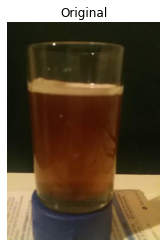

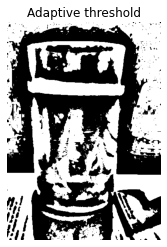

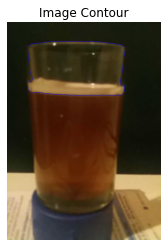

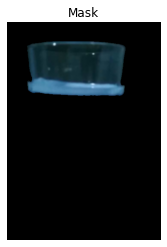

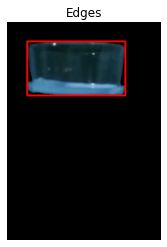

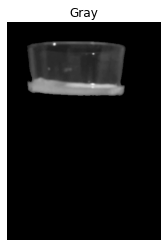

INFO:__main__:Output image: (568, 400, 3)


In [100]:
img = cv.imread('../img/01_17_2022_22_25_57.jpg')

width, height = img.shape[:2]
img = img[width // 5: width]
print(width, height)
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# plt.axis('off')
# plt.imshow(img)

Detector.from_image(img)